In [ ]:
!pip install shap
!pip install alibi

     |████████████████████████████████| 358kB 5.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491629 sha256=2fe7649f54fafb3d118d84f30d085bd51721accbe3ef776a35c9e394e38f1744
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 317kB 5.7MB/s 
     |████████████████████████████████| 28.0MB 102kB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052145 sha256=afbcc1559441c8e70623b3c794aabd36121d24806780be628cf92b2a5b057ff0
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built spacy-lookups-data


In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import seaborn as sns
sns.set()

train_values = np.empty(shape=[0, 222])
test_values = np.empty(shape=[0, 222])

train_sampled_all = glob.glob('./drive/MyDrive/compsci/train_sampled_all_220.csv')
# test_all = glob.glob('./drive/MyDrive/compsci/test_sampled_all_centered.csv')
test_sampled_all = glob.glob('./drive/MyDrive/compsci/test_unsampled_all_220.csv')

for j in train_sampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)
    
# for j in test_all:
#     print('Loading ', j)
#     csvrows = np.loadtxt(j, delimiter=',')
#     test_values = np.append(test_values, csvrows, axis=0)

for j in test_sampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

y_train = train_values[:,-2]
y_test = test_values[:,-2]

Loading  ./drive/MyDrive/compsci/train_sampled_all_220.csv
Loading  ./drive/MyDrive/compsci/test_unsampled_all_220.csv
(31912, 222)
(37863, 222)


In [ ]:
from itertools import islice

def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return

a = X_train
new_X_train = []
for i in range(len(X_train)):
  means = list(means_of_slices(a[i], 20))
  new_X_train.append(means)
X_train = np.array(new_X_train)
# X_train = []
# for i in new_X_train:
#   X_train.append(np.repeat(i,17))
# X_train = np.array(X_train)
# print(X_train.shape)

b = X_test
new_X_test = []
for i in range(len(X_test)):
  means = list(means_of_slices(b[i], 20))
  new_X_test.append(means)
X_test = np.array(new_X_test)
# X_test = []
# for i in new_X_test:
#   X_test.append(np.repeat(i,17))
# X_test = np.array(X_test)
# print(X_test.shape)

In [ ]:
# using NN Multi Layer Perceptron classifier
from sklearn.neural_network import MLPClassifier
NNMLP_clf = MLPClassifier(random_state=48, max_iter=100)
NNMLP_clf.fit(X_train, y_train)
print('NNMLP Results')
y_pred_NNMLP = NNMLP_clf.predict(X_test)
print(NNMLP_clf.score(X_test, y_test))

NNMLP Results
0.8925071969997095


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Computing partial dependence plots...


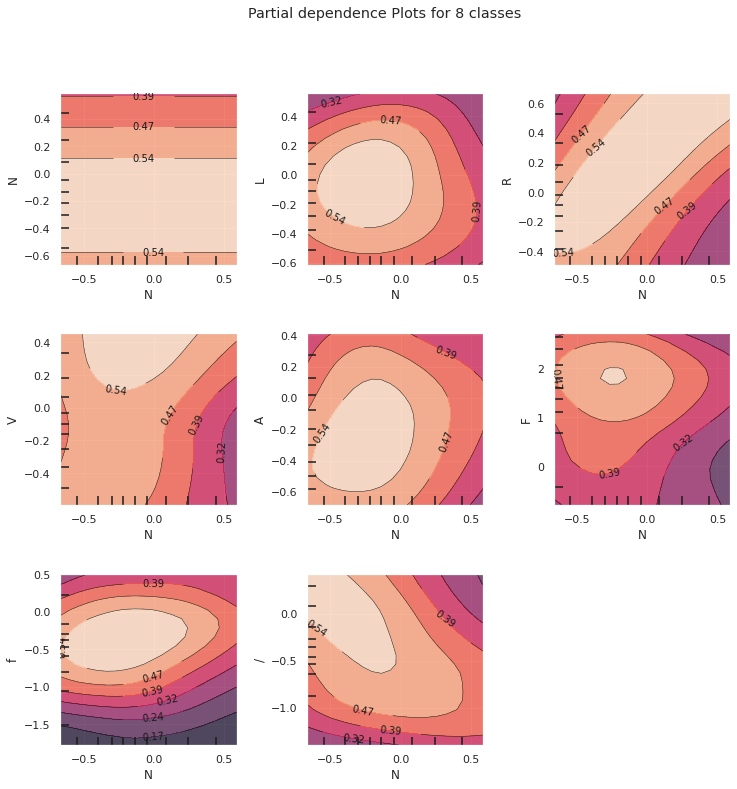

In [ ]:
from sklearn.inspection import plot_partial_dependence

features=np.array([(0,0),(0,1),(0,2),(0,3),(0,4),(0,5),(0,6),(0,7)])
feature_names=np.array(['N','L','R','V','A','F','f','/'])

print('Computing partial dependence plots...')
plot_partial_dependence(NNMLP_clf, 
                        features=features,
                        feature_names=feature_names,
                        X=X_test,
                        target=1,
                        grid_resolution=20)

fig = plt.gcf()
fig.suptitle('Partial dependence Plots for 8 classes')
fig.subplots_adjust(wspace=0.4, hspace=0.4)
fig.set_size_inches(12,12)

Computing partial dependence plots...


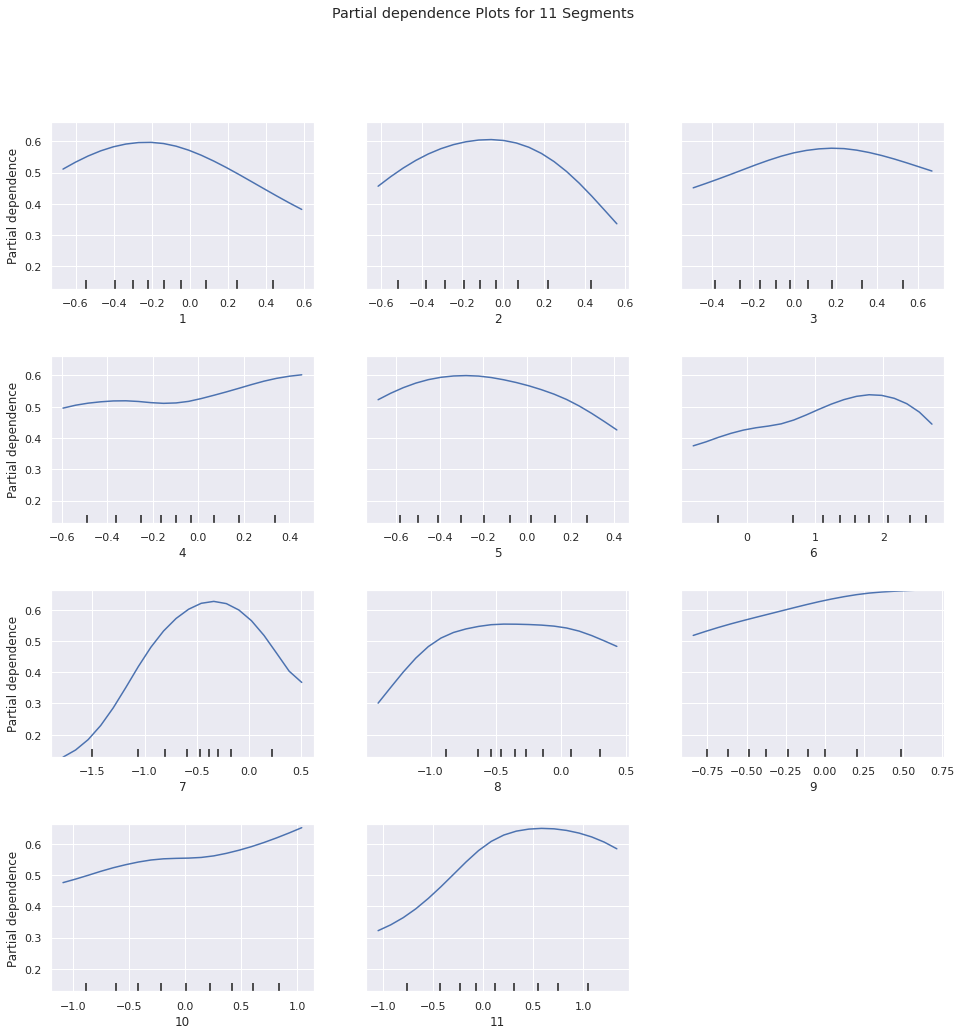

In [ ]:
from sklearn.inspection import plot_partial_dependence

features=np.array([0,1,2,3,4,5,6,7,8,9,10])
feature_names=np.array(['1','2','3','4','5','6','7','8','9','10','11'])

print('Computing partial dependence plots...')
plot_partial_dependence(NNMLP_clf, 
                        features=features,
                        feature_names=feature_names,
                        X=X_test,
                        target=1,
                        grid_resolution=20)

fig = plt.gcf()
fig.suptitle('Partial dependence Plots for 11 Segments')
fig.subplots_adjust(wspace=0.2, hspace=0.4)
fig.set_size_inches(16,16)

In [ ]:
import shap
from alibi.explainers import KernelShap
from sklearn import svm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
np.random.seed(0)
classifier = SVC(
    kernel = 'rbf',
    C=1,
    gamma = 'auto',
    decision_function_shape='ovr',  # n_cls trained with data from one class as postive and remainder of data as neg
    random_state = 42,
)
classifier.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
feature_names = ['N','L','R','V','A','F','f','/']
target_names = ['N','L','R','V','A','F','f','/']

Text(0.5, 1.0, 'Confusion matrix for SVC classifier')

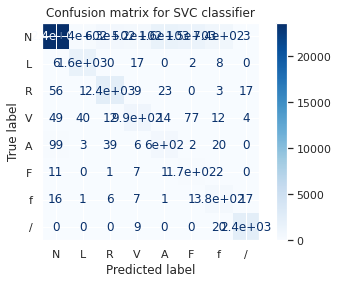

In [ ]:
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

title = 'Confusion matrix for SVC classifier'
disp = plot_confusion_matrix(classifier,
                             X_test,
                             y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

In [ ]:
pred_fcn = classifier.decision_function

np.random.seed(0)
svm_explainer = KernelShap(pred_fcn)
svm_explainer.fit(X_train,summarise_background=True)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': True,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [ ]:
# expected_values attribute stores average scores across training set for every binary SVM
mean_scores_train = pred_fcn(X_train).mean(axis=0)
# are stored in the expected value attibute of the explainer ...
print(mean_scores_train - svm_explainer.expected_value)

[-0.0856965   0.02571948 -0.07715732  0.16451119 -0.02177699 -0.00238014
 -0.02817961  0.0122857 ]


In [ ]:
svm_explanation = svm_explainer.explain(X_test[:50,:], l1_reg=False, summarise_background=True, nsamples=50)

In [ ]:
idx = 2
instance = X_test[idx][None, :]
pred = classifier.predict(instance)
scores =  classifier.decision_function(instance)
class_idx = 0
print("The predicted class for the X_test[{}] is {}.".format(idx, *pred))
print("OVR decision function values are {}.".format(*scores))

The predicted class for the X_test[2] is 1.0.
OVR decision function values are [ 7.30605061  2.72607646  1.70980129  0.70419009  5.2713589   4.26902989
  6.29194531 -0.29462806].


In [ ]:
shap.initjs()
shap.force_plot(
    svm_explainer.expected_value[class_idx],
    svm_explanation.shap_values[class_idx][idx, :] ,
    instance,
    feature_names,
)

In [ ]:
def class_labels(classifier, instance, class_names=None):
    """
    Creates a set of legend labels based on the decision
    scores of a classifier and, optionally, the class names.
    """

    decision_scores = classifier.decision_function(instance)

    if not class_names:
        class_names = [f'Class {i}' for i in range(decision_scores.shape[1])]

    for i, score in enumerate(np.nditer(decision_scores)):
        class_names[i] = class_names[i] + ' ({})'.format(round(score.item(),3))

    return class_names

legend_labels = class_labels(classifier, instance)
legend_labels = feature_names

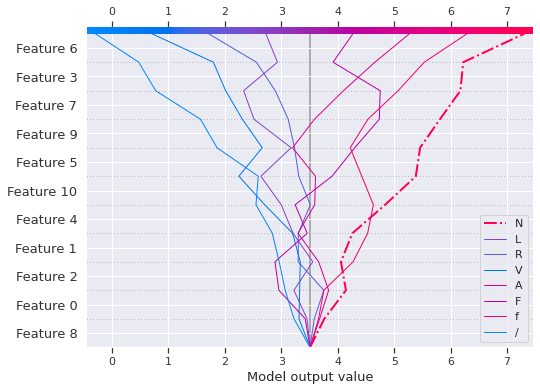

In [ ]:
shap.initjs()
r = shap.multioutput_decision_plot(svm_explainer.expected_value.tolist(),
                                   svm_explanation.shap_values,
                                   idx,
                                  #feature_names=feature_names,
                                   feature_order='importance',
                                   highlight=[class_idx],
                                   legend_labels=legend_labels,
                                   return_objects=True,
                                   legend_location='lower right')

In [ ]:
idx =  0
instance = X_test[idx][None, :]
pred = classifier.predict(instance)

instance_shap = np.array(svm_explanation.shap_values)[:, idx, :]
feature_order = np.argsort(np.sum(np.abs(instance_shap),axis=0))[::]

In [ ]:
class_idx = 0 # we explain the predicted label
shap.initjs()
shap.force_plot(
    svm_explainer.expected_value[class_idx],
    svm_explanation.shap_values[class_idx],
    X_test,
    feature_names=feature_names,
)

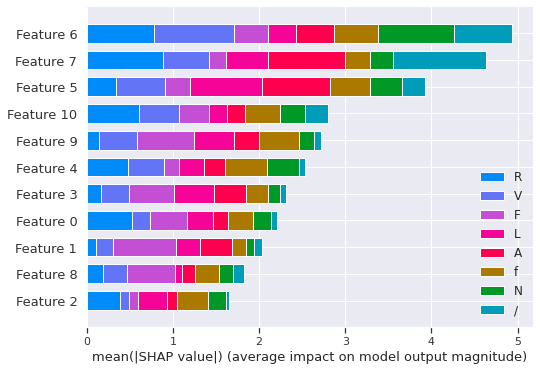

In [ ]:
shap.summary_plot(svm_explanation.shap_values, X_test,class_names=feature_names)